# Proprocess

### Imports

In [1]:
import pandas as pd
import cv2
import os
from matplotlib import pyplot as plt

## Pre-processing

### Merged bbox and annotations

In [2]:
bbox = pd.read_csv("content/bbox.csv")
annotations = pd.read_csv("content/annotations.csv")

bbox["image_name_clean"] = bbox["image_name"].str.lower().str.strip()
annotations["path_clean"] = annotations["path"].str.lower().str.strip()

merged = pd.merge(bbox, annotations, left_on="image_name_clean", right_on="path_clean", how="inner")

print("merged: ", len(merged))

merged.head()

merged:  160


,label_name,bbox_x,bbox_y,bbox_width,bbox_height,image_name,image_width,image_height,image_name_clean,identity,path,orientation,date,path_clean
0,head,1214,888,645,561,leftIMG_0328.jpeg,5472,3648,leftimg_0328.jpeg,SE010,leftIMG_0328.jpeg,left,24_06_2021,leftimg_0328.jpeg
1,head,1511,966,1110,736,leftIMG_0344.jpg,5472,3648,leftimg_0344.jpg,G16-03,leftIMG_0344.jpg,left,14_06_2019,leftimg_0344.jpg
2,head,847,2974,846,855,leftIMG_0597.jpg,3648,5472,leftimg_0597.jpg,G16-03,leftIMG_0597.jpg,left,21_06_2018,leftimg_0597.jpg
3,head,1692,850,1110,1026,leftIMG_0715.jpg,5472,3648,leftimg_0715.jpg,G18-04,leftIMG_0715.jpg,left,15_06_2019,leftimg_0715.jpg
4,head,1569,785,723,523,leftIMG_0751.jpeg,5472,3648,leftimg_0751.jpeg,t573,leftIMG_0751.jpeg,left,25_06_2021,leftimg_0751.jpeg


### Cropped turtle head

In [3]:
import cv2
import os

output_dir = "dataset_turtle_cropped"
os.makedirs(output_dir, exist_ok=True)

for _, row in merged.iterrows():
    img_path = os.path.join("content/images", row["image_name"])
    if not os.path.exists(img_path):
        continue

    img = cv2.imread(img_path)
    if img is None:
        continue

    x, y, w, h = int(row["bbox_x"]), int(row["bbox_y"]), int(row["bbox_width"]), int(row["bbox_height"])
    crop = img[y:y+h, x:x+w]

    # create folder
    id_folder = os.path.join(output_dir, row["identity"])
    os.makedirs(id_folder, exist_ok=True)

    # save
    save_path = os.path.join(id_folder, row["image_name"])
    cv2.imwrite(save_path, crop)

### dataset_turtle_preprocessed
- grayscale
- Noise reduction (Gaussian blur)
- Histogram equalization
- Resize to standard size

In [4]:
import cv2
import os
from pathlib import Path

cropped_dir = "dataset_turtle_cropped"

preprocessed_dir = "dataset_turtle_preprocessed"
os.makedirs(preprocessed_dir, exist_ok=True)

standard_size = (224, 224)

for identity_folder in os.listdir(cropped_dir):
    cropped_identity_path = os.path.join(cropped_dir, identity_folder)

    if not os.path.isdir(cropped_identity_path):
        continue

    preprocessed_identity_path = os.path.join(preprocessed_dir, identity_folder)
    os.makedirs(preprocessed_identity_path, exist_ok=True)

    for img_name in os.listdir(cropped_identity_path):
        img_path = os.path.join(cropped_identity_path, img_name)

        if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        img = cv2.imread(img_path)
        if img is None:
            continue

        # grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Noise reduction (Gaussian blur)
        denoised = cv2.GaussianBlur(gray, (5, 5), 0)

        # Histogram equalization
        equalized = cv2.equalizeHist(denoised)

        # Resize to standard size
        resized = cv2.resize(equalized, standard_size)

        # Save
        save_path = os.path.join(preprocessed_identity_path, img_name)
        cv2.imwrite(save_path, resized)

        print(f"Preprocessed: {identity_folder}/{img_name}")

print(f"Pre-processing complete!!!!!!! Images saved to {preprocessed_dir}")

Preprocessed: beach031/leftIMG_2623.JPG
Preprocessed: beach031/leftIMG_9503.JPG
Preprocessed: beach031/rightIMG_2620.JPG
Preprocessed: beach031/rightIMG_9509.JPG
Preprocessed: CZS20-09/leftIMG_3995.JPG
Preprocessed: CZS20-09/leftIMG_9475.jpeg
Preprocessed: CZS20-09/rightIMG_3990.JPG
Preprocessed: CZS20-09/rightIMG_9469.jpeg
Preprocessed: G15-03/leftIMG_2832.JPG
Preprocessed: G15-03/leftIMG_3727.JPG
Preprocessed: G15-03/rightIMG_2835.JPG
Preprocessed: G15-03/rightIMG_3731.JPG
Preprocessed: G16-03/leftIMG_0344.jpg
Preprocessed: G16-03/leftIMG_0597.jpg
Preprocessed: G16-03/rightIMG_0349.jpg
Preprocessed: G16-03/rightIMG_0592.JPG
Preprocessed: G16-25/leftIMG_0958.JPG
Preprocessed: G16-25/leftIMG_1300.JPG
Preprocessed: G16-25/rightIMG_0961.JPG
Preprocessed: G16-25/rightIMG_1280.JPG
Preprocessed: G16-43/leftIMG_1054.jpg
Preprocessed: G16-43/leftIMG_7150.JPG
Preprocessed: G16-43/rightIMG_1057.jpg
Preprocessed: G16-43/rightIMG_7144.JPG
Preprocessed: G17-02/leftIMG_2799.JPG
Preprocessed: G17-02

# Data Augmentation

> Add blockquote



### dataset_turtle_preprocessed_Augmentation
อันนี้เพิ่ม
- Augmentation เข้าไป (ทำ 3 ครั้งต่อ 1 ภาพ)

In [5]:
import cv2
import os
import albumentations as A

preprocessed_dir = "dataset_turtle_preprocessed"
output_dir = "dataset_turtle_preprocessed_Augmentation"
os.makedirs(output_dir, exist_ok=True)

STANDARD_SIZE = (224, 224)

# Augmentation pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5)
])

for identity_folder in os.listdir(preprocessed_dir):
    identity_path = os.path.join(preprocessed_dir, identity_folder)
    if not os.path.isdir(identity_path):
        continue

    output_identity_path = os.path.join(output_dir, identity_folder)
    os.makedirs(output_identity_path, exist_ok=True)

    for img_name in os.listdir(identity_path):
        img_path = os.path.join(identity_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        # Noise reduction + CLAHE
        img = cv2.GaussianBlur(img, (5,5), 0)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img = clahe.apply(img)

        # Resize
        img = cv2.resize(img, STANDARD_SIZE)

        # Save original preprocessed
        save_path = os.path.join(output_identity_path, img_name)
        cv2.imwrite(save_path, img)

        # Augmentation (3 versions)
        for i in range(3):
            augmented = transform(image=img)
            aug_img = augmented['image']
            aug_name = img_name.replace(".", f"_aug{i}.")
            cv2.imwrite(os.path.join(output_identity_path, aug_name), aug_img)

print(f"All images preprocessed and augmented! Saved to {output_dir}")


/home/philiphousden/miniconda3/envs/tf/lib/python3.9/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


All images preprocessed and augmented! Saved to dataset_turtle_preprocessed_Augmentation


### Segmenation 

In [16]:
from ultralytics import YOLO

# Load the YOLO model
model = YOLO("yolov8n-seg.pt")

# Train the model on your dataset
model.train(
    data="data.yaml",  
    epochs=50,
    imgsz=640
)

New https://pypi.org/project/ultralytics/8.3.223 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.203 🚀 Python-3.9.21 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 8188MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=No

ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f42380c0250>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041, 

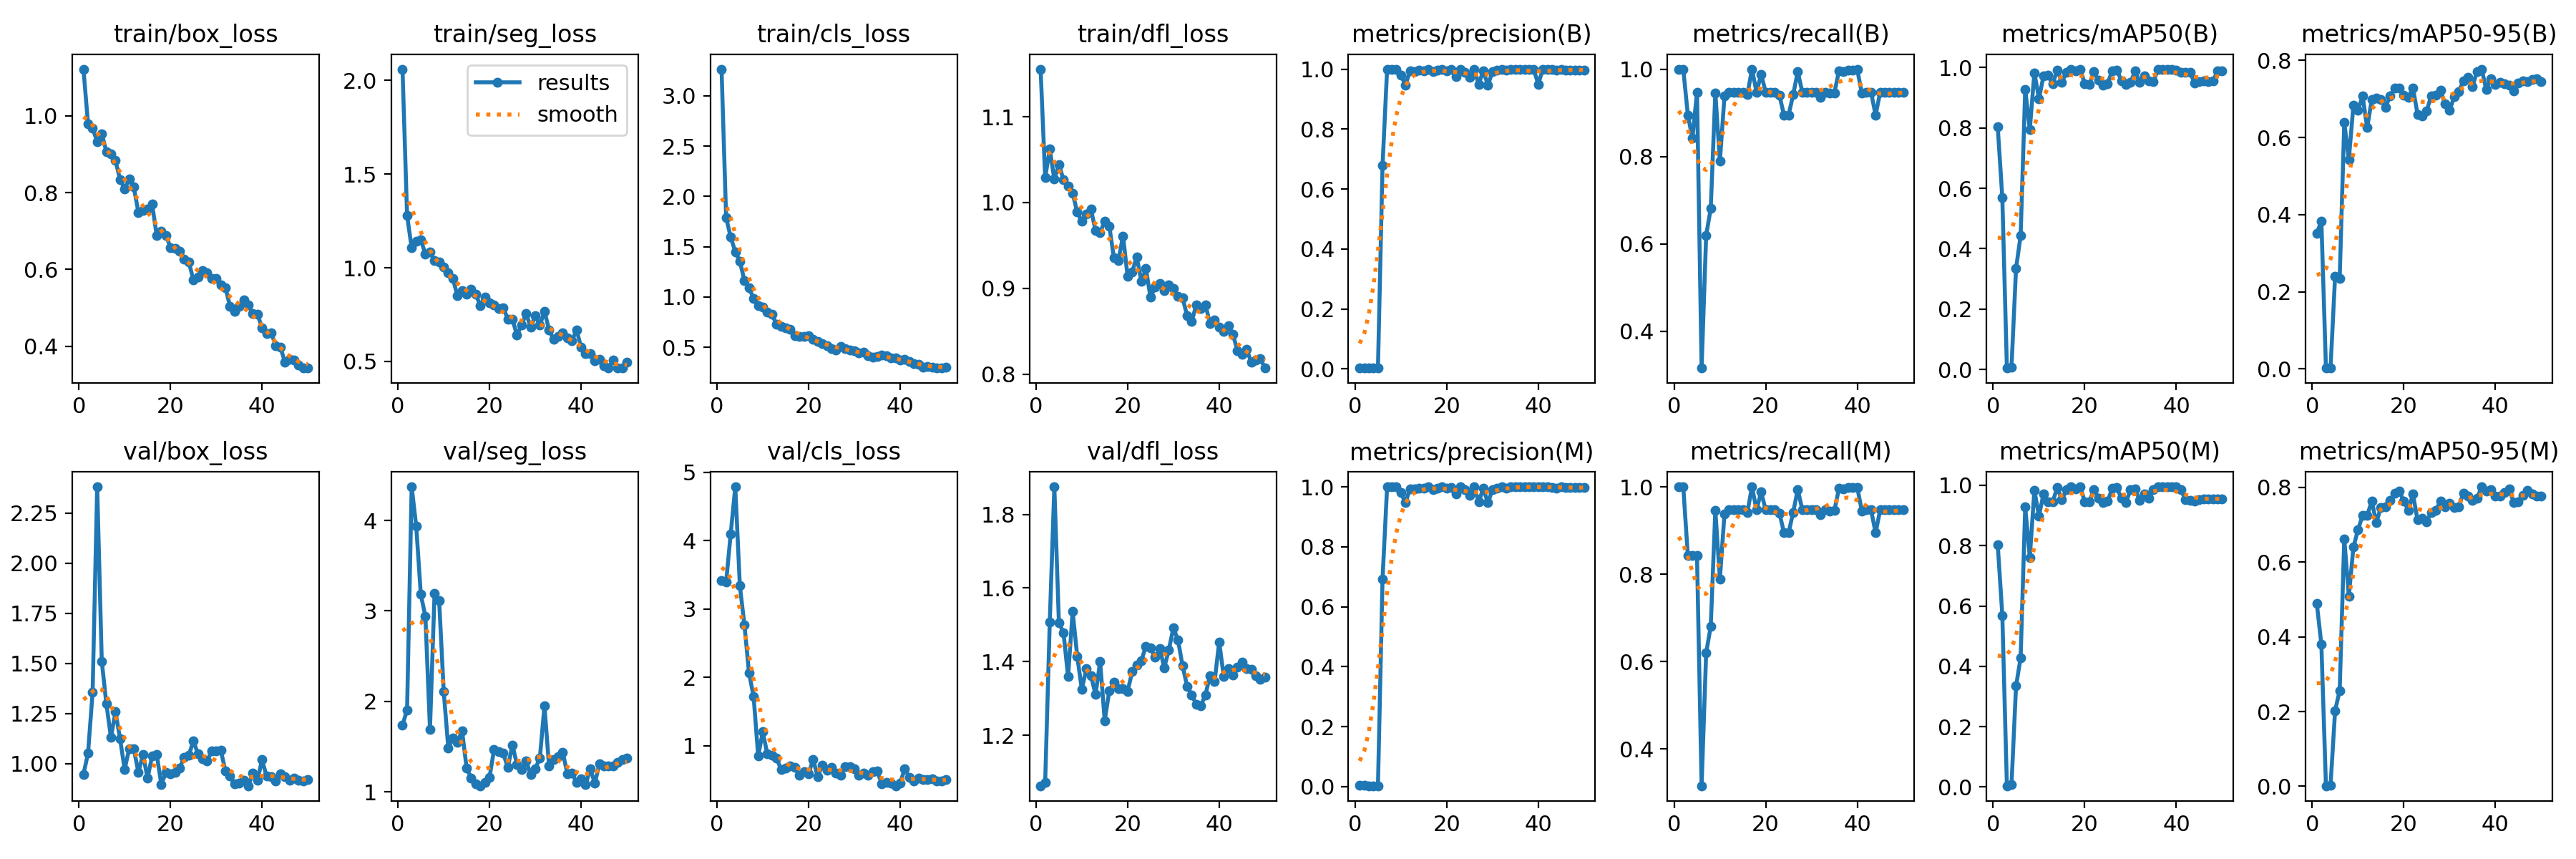

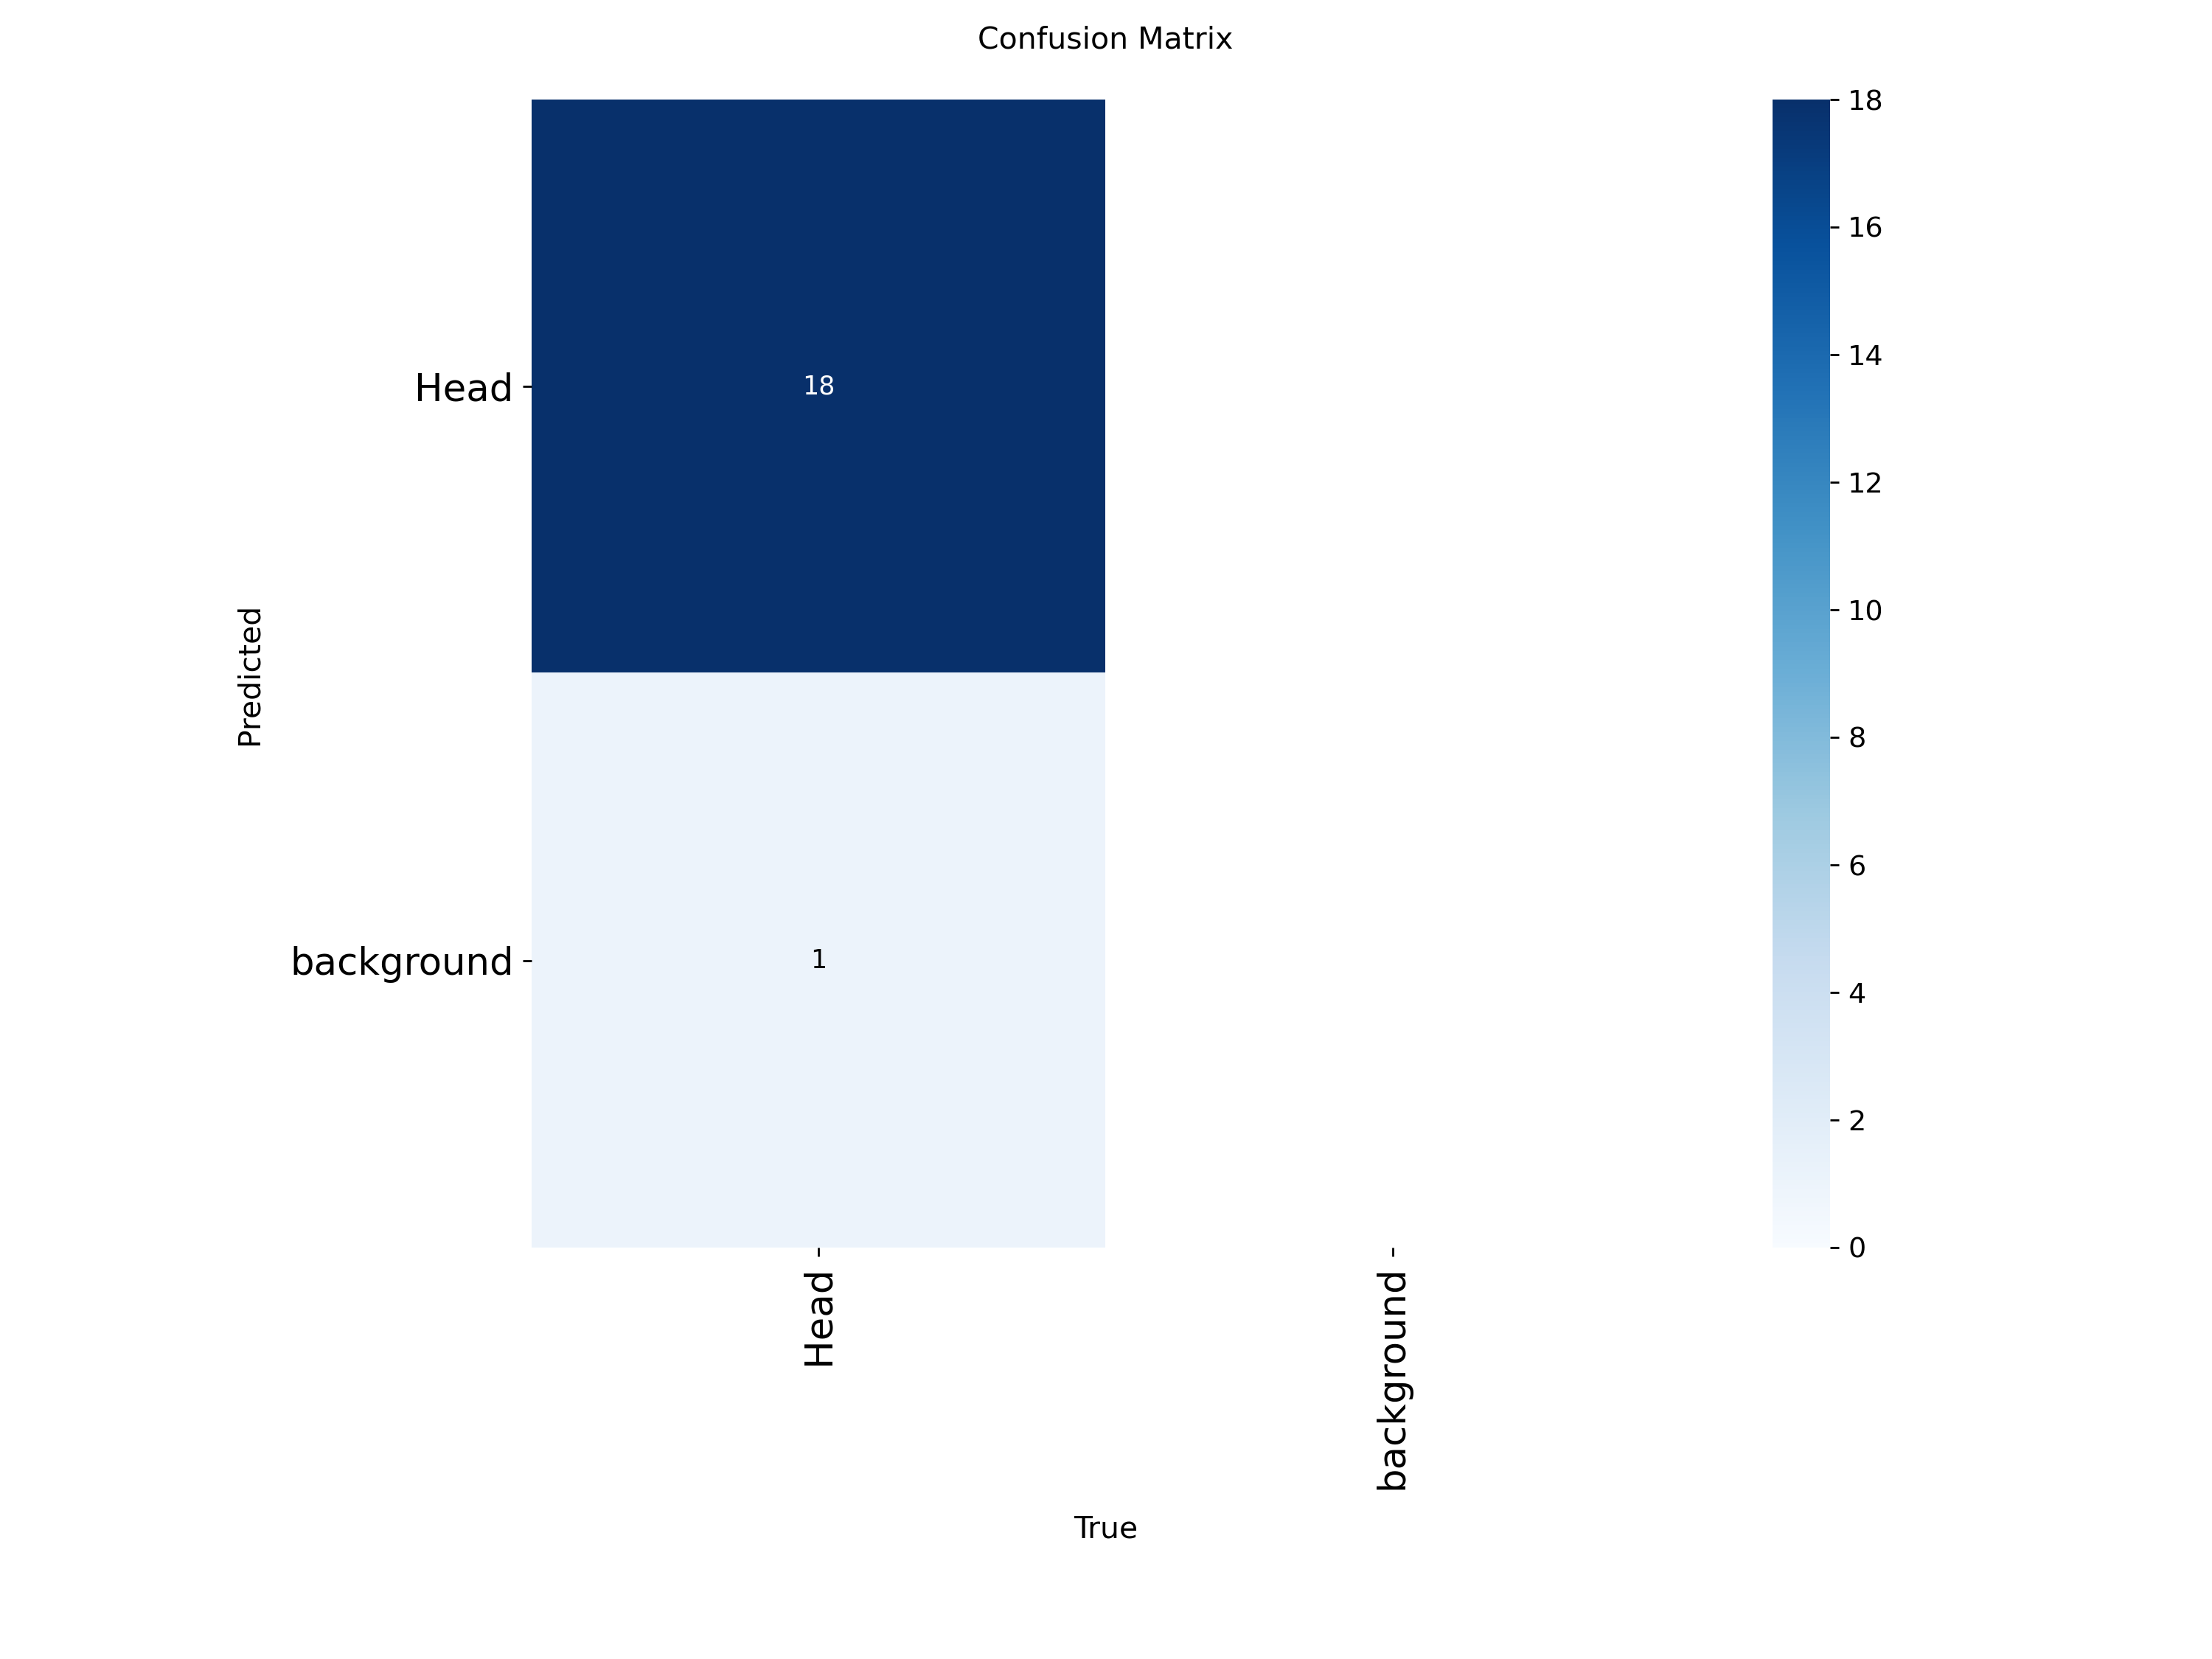

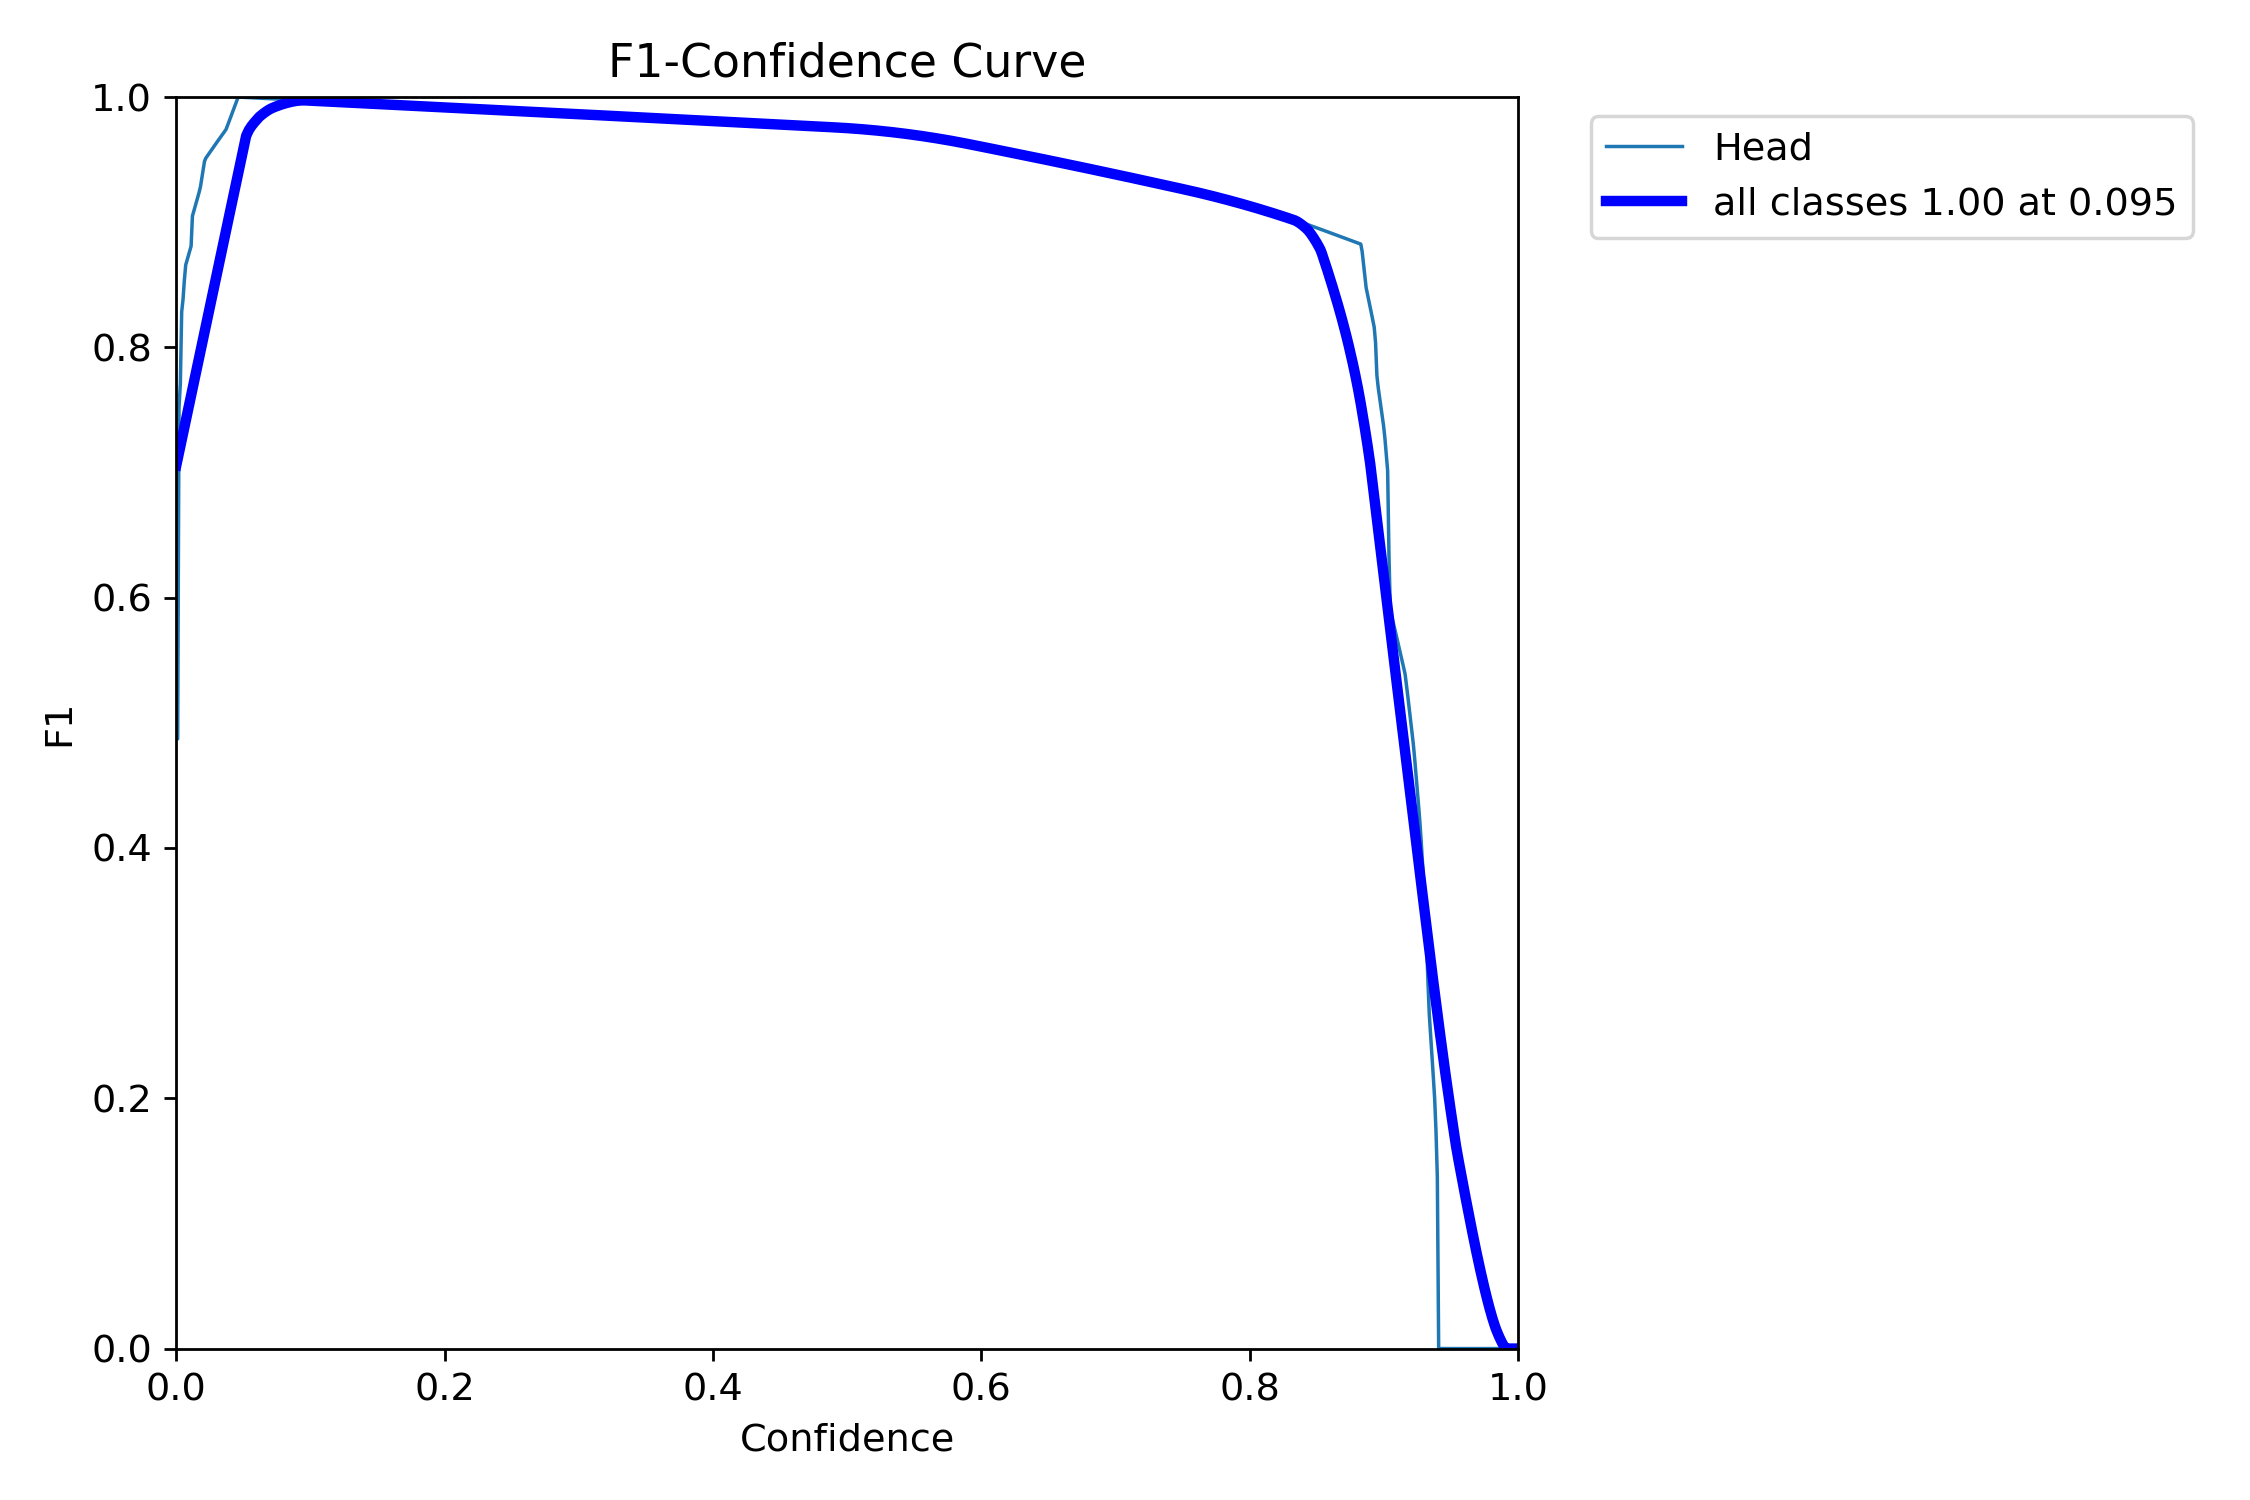

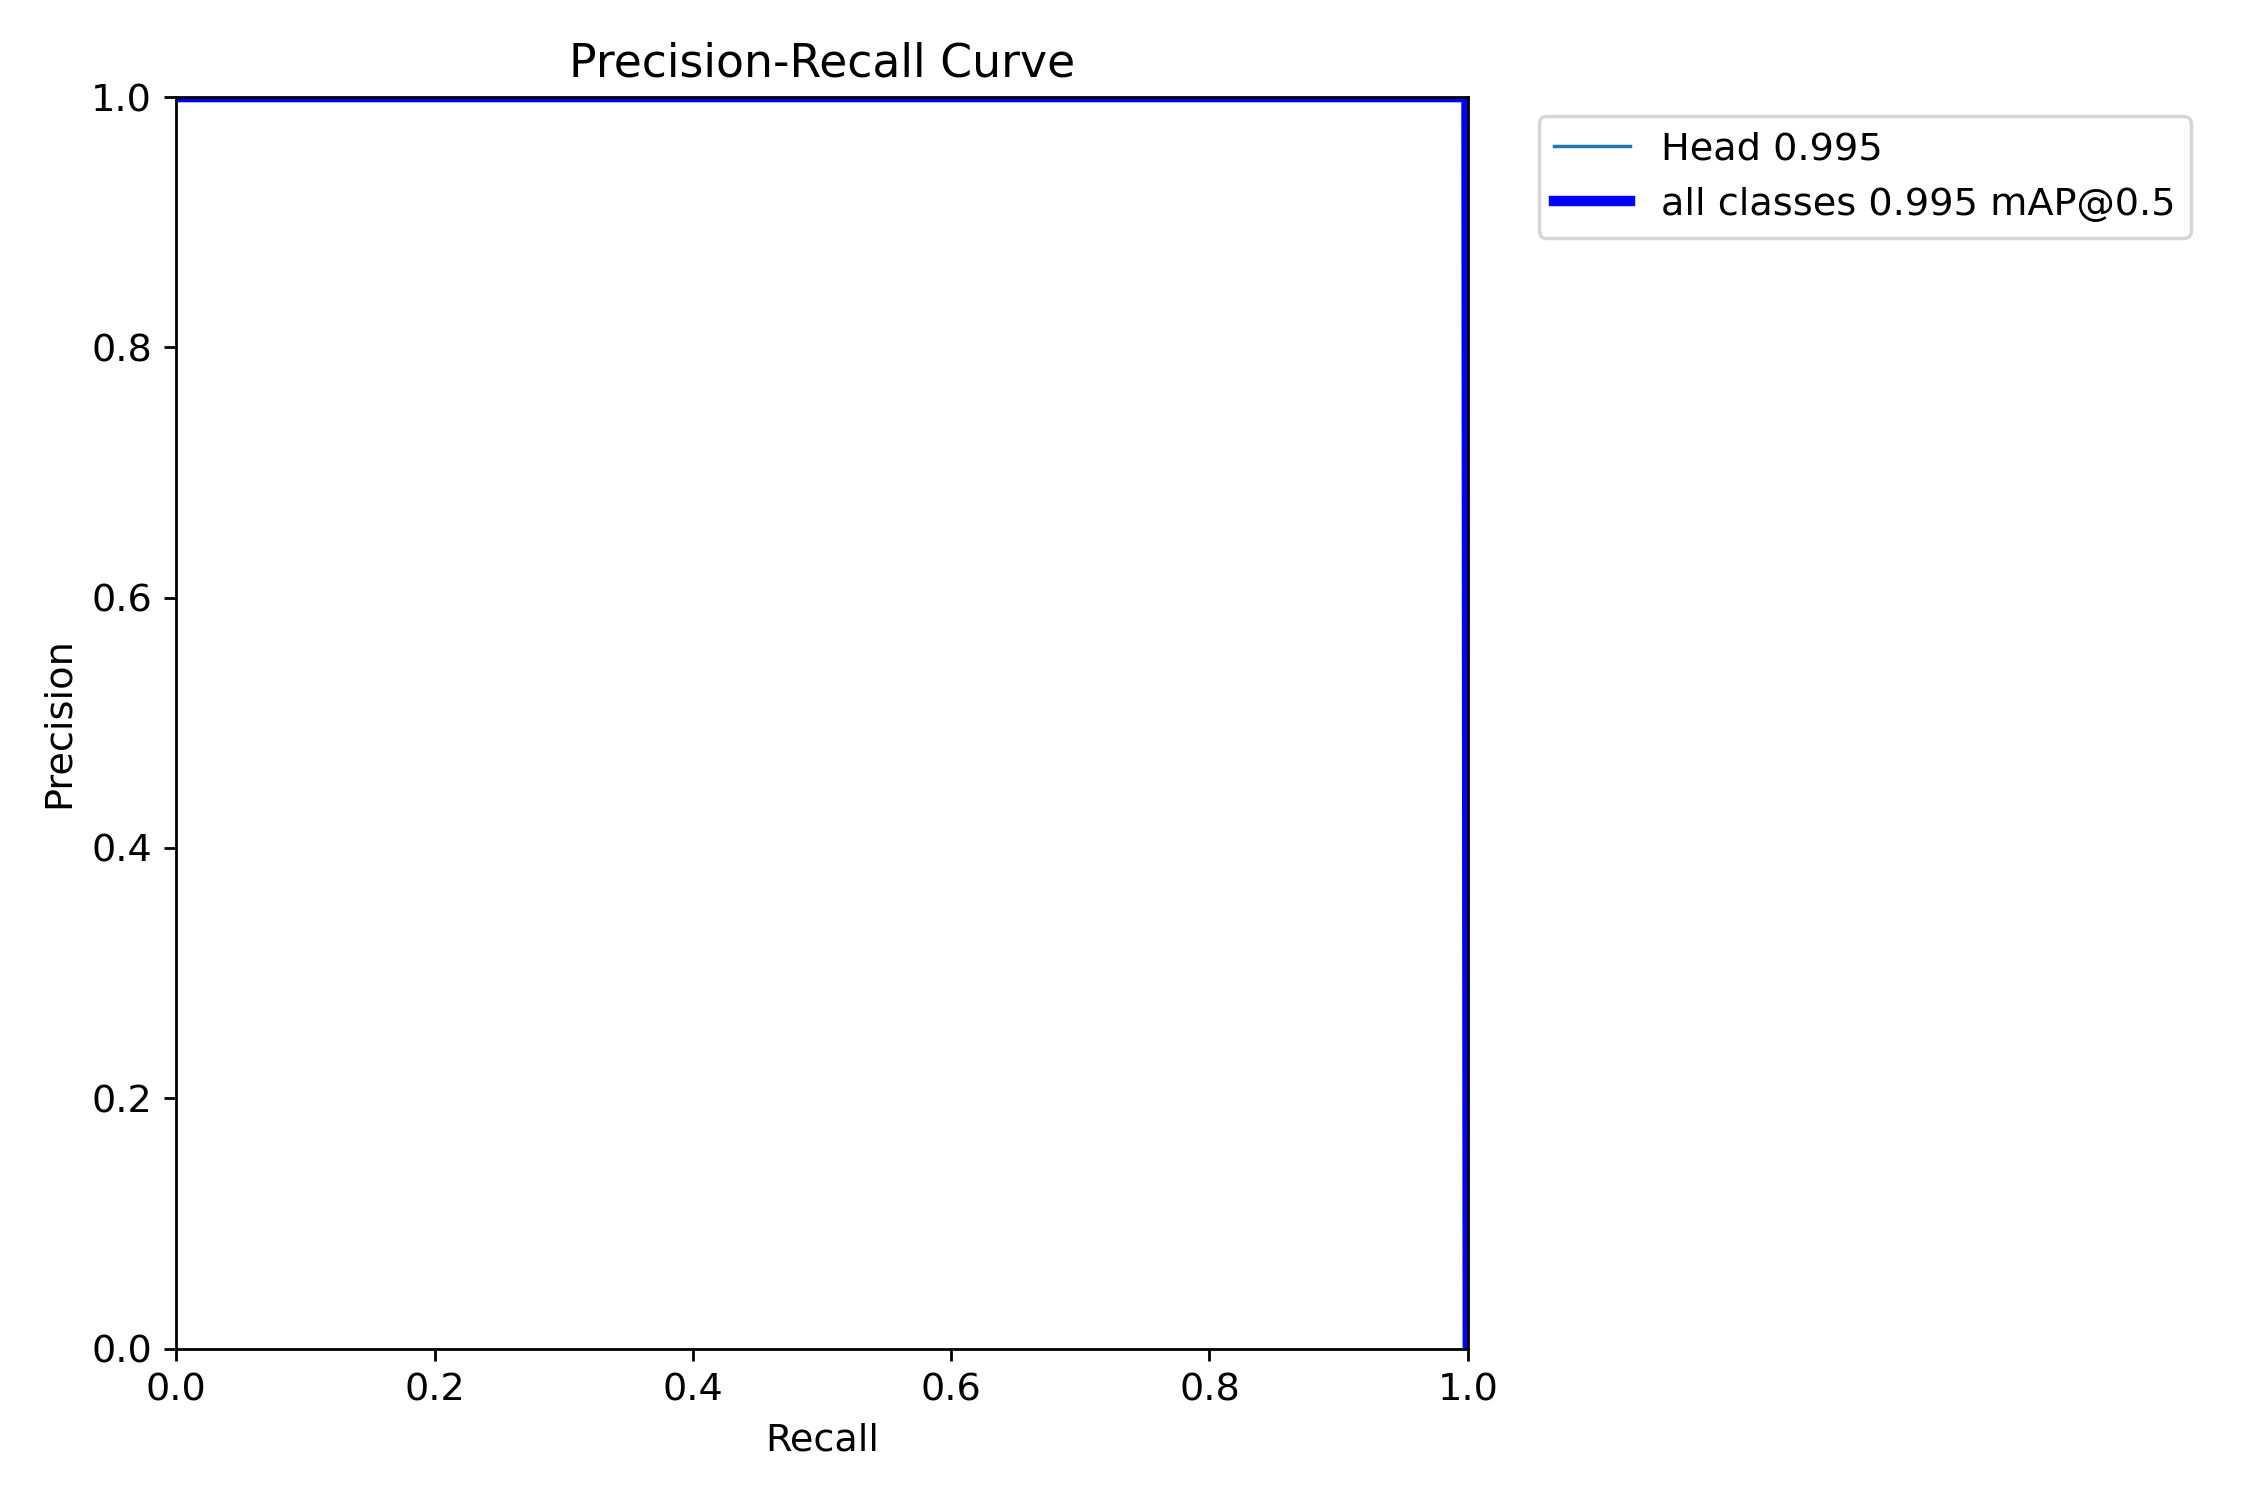

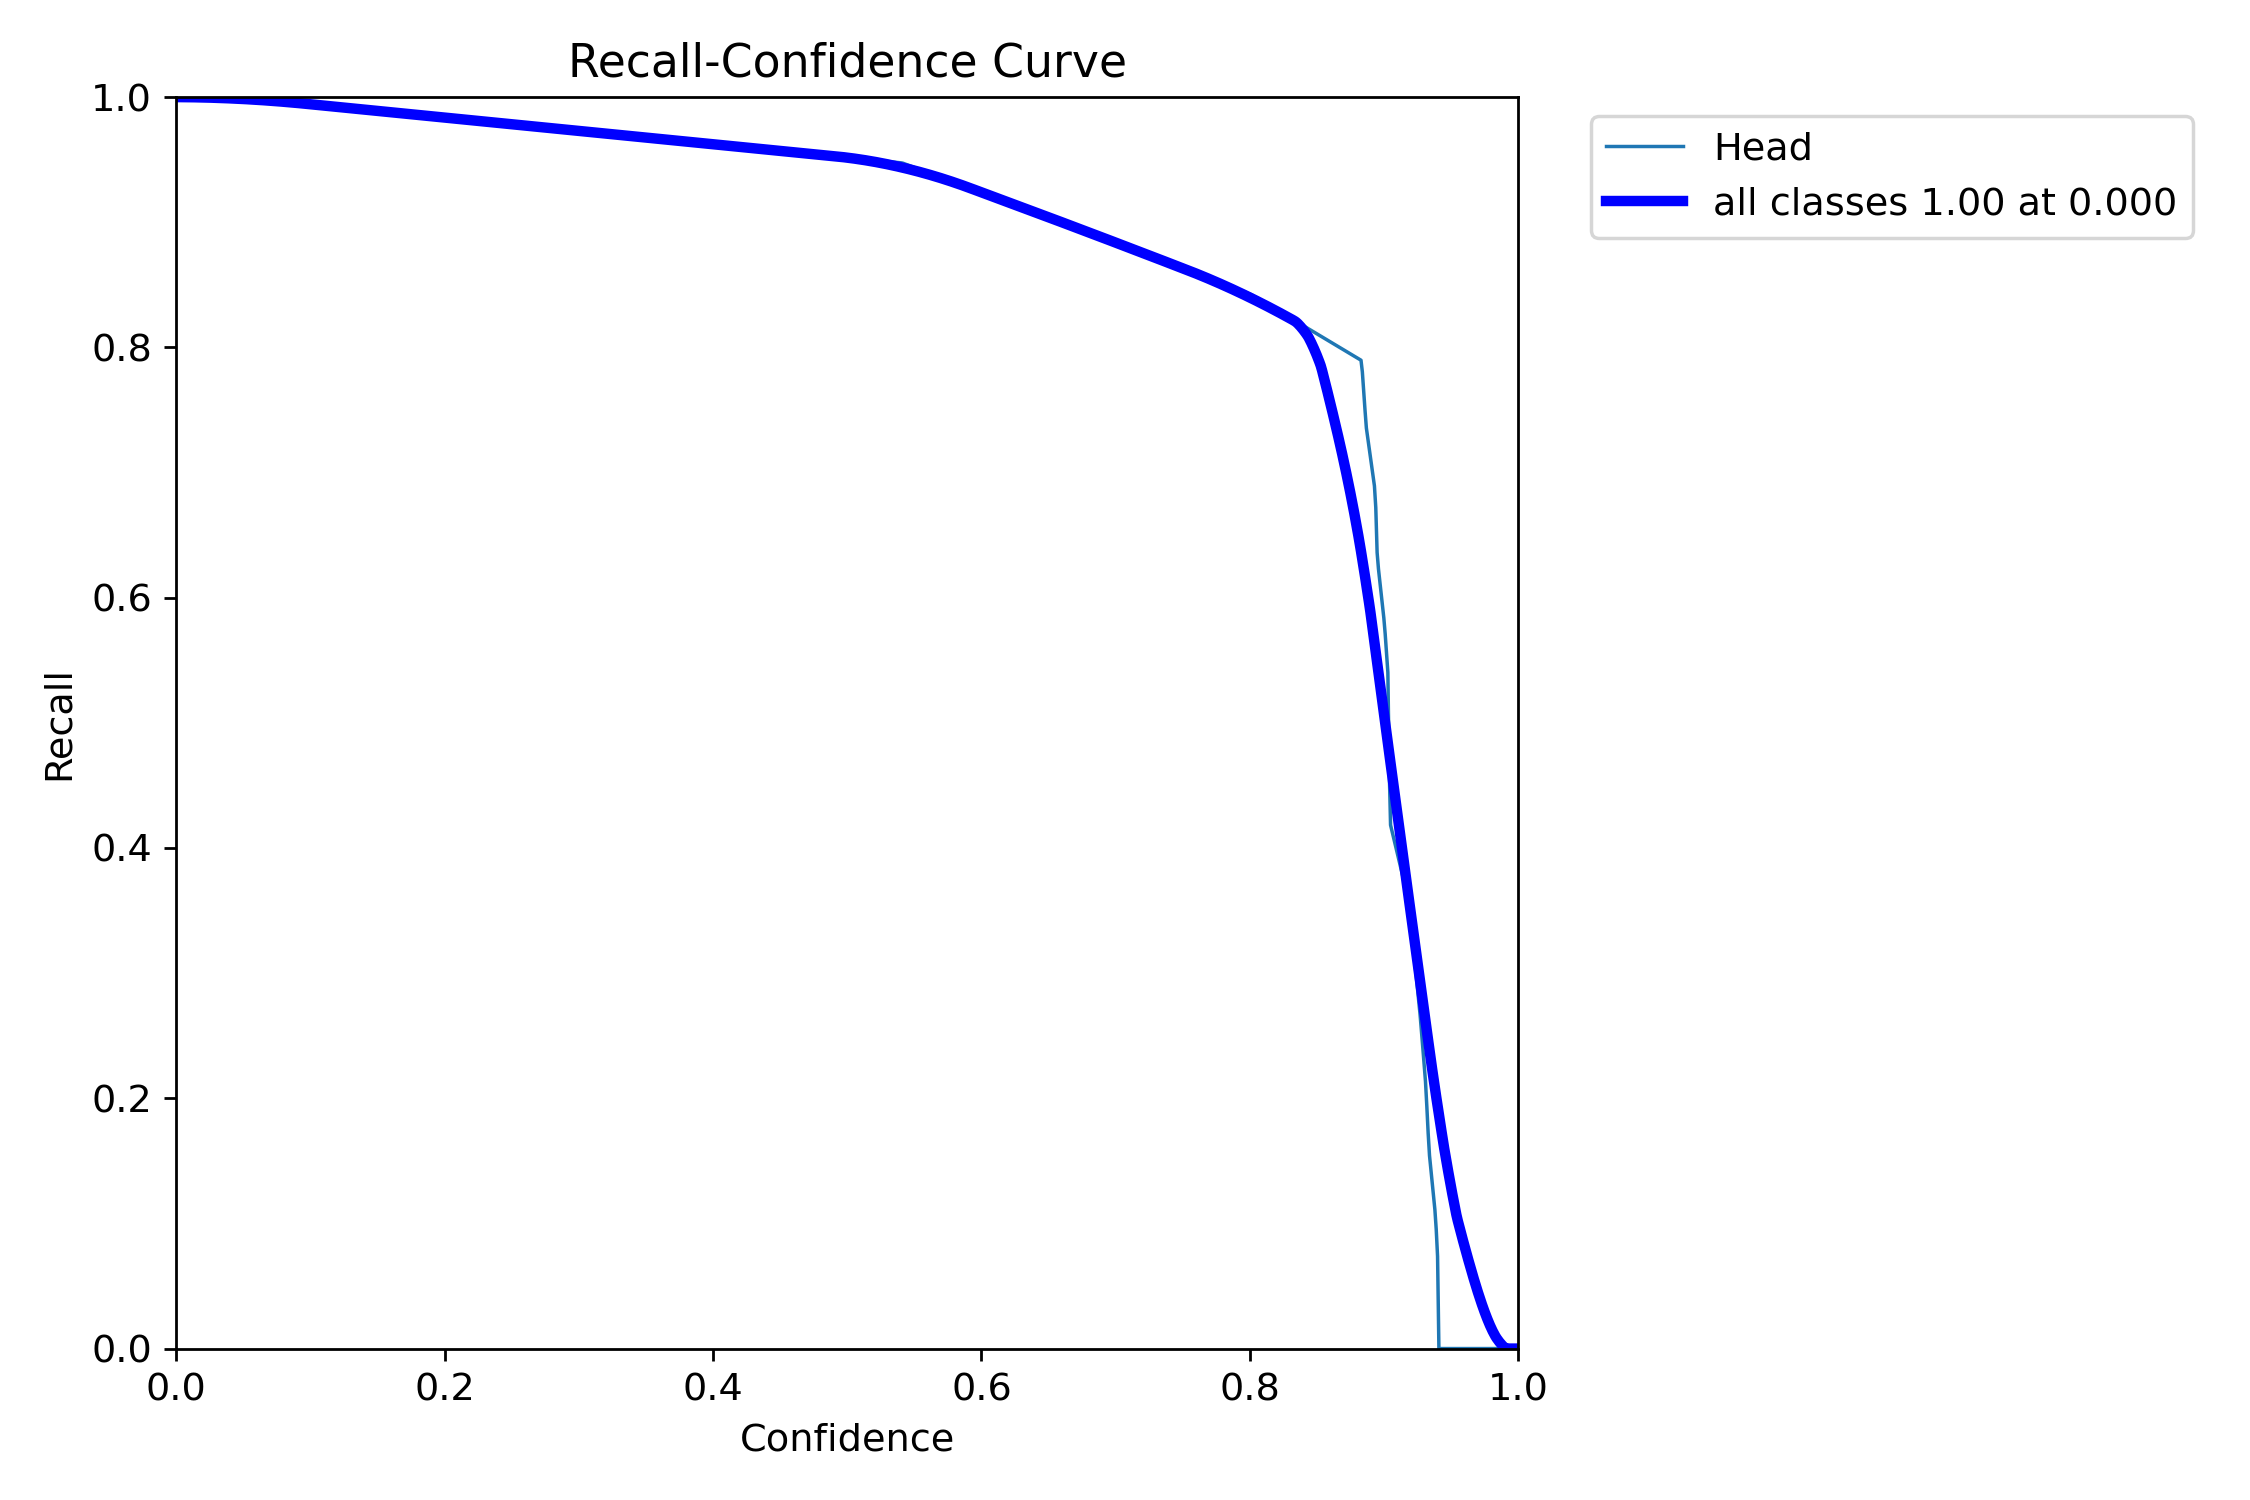

In [23]:
model = YOLO("runs/segment/train2/weights/best.pt")

from IPython.display import Image, display

# Correct folder for training metrics
train_path = "runs/segment/train2/"

for file in [
    "results.png",
    "confusion_matrix.png",
    "MaskF1_curve.png",
    "MaskPR_curve.png",
    "MaskR_curve.png",
]:
    display(Image(filename=train_path + file))

### HOG Feature Extraction 

In [25]:
import numpy as np
import pickle
from tqdm import tqdm
from skimage.feature import hog

# Input directory (use your preprocessed dataset)
input_dir = "dataset_turtle_preprocessed_Augmentation"

features_dict = {}

# Loop over each turtle identity
for identity in os.listdir(input_dir):
    id_path = os.path.join(input_dir, identity)
    if not os.path.isdir(id_path):
        continue

    feature_list = []

    for img_name in tqdm(os.listdir(id_path), desc=f"Extracting {identity}"):
        img_path = os.path.join(id_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        # Ensure consistent size
        img = cv2.resize(img, (128, 128))

        # Compute HOG features
        features = hog(
            img,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            block_norm='L2-Hys',
            transform_sqrt=True
        )

        feature_list.append(features)

    if len(feature_list) > 0:
        features_dict[identity] = np.stack(feature_list)

# Save features
with open("turtle_features_hog.pkl", "wb") as f:
    pickle.dump(features_dict, f)

print("✅ HOG feature extraction complete! Saved to turtle_features_hog.pkl")

Extracting YT008: 100%|██████████| 16/16 [00:00<00:00, 131.44it/s]


✅ HOG feature extraction complete! Saved to turtle_features_hog.pkl


### Compare Two Images

In [26]:
from sklearn.metrics.pairwise import cosine_similarity
import random

# Pick two identities
id1, id2 = random.sample(list(features_dict.keys()), 2)

# Pick first feature from each
feat1 = features_dict[id1][0].reshape(1, -1)
feat2 = features_dict[id2][0].reshape(1, -1)

sim = cosine_similarity(feat1, feat2)[0][0]
print(f"Similarity between {id1} and {id2}: {sim:.4f}")

Similarity between SE010 and t584: 0.7296
